In [1]:
import numpy as np
from numpy import *
from matplotlib.ticker import FuncFormatter
from matplotlib import collections  as mc
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd
import os.path
import os
import glob


In [2]:
def splitgff(file):
    l=[]
    with open(file, "r") as f:
        for line in f:
            if line.startswith("Command"):
                pass
            elif line.startswith("Hostname"):
                pass
            elif line.startswith("--"):
                pass
            else:
                l.append(line)
    indices = [-1] + [i for i, x in enumerate(l) if x.startswith('#')] + [len(l)]
    sublists = [l[indices[i]+1:indices[i+1]] for i in range(len(indices)-1)]

    return [sublist for sublist in sublists if sublist]


In [3]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

In [4]:
import math

In [5]:
gffs = {}

# Loop through each GFF file
for name in glob.glob('../../Batch Export/final_modified*gff'):
    gffs[name] = pd.read_csv(name, sep='\t', header=None, comment='#')

    _ = []
    count = 0
    for n, i in enumerate(gffs[name][8]):
        if isinstance(i, float) and math.isnan(i):
            count += 1
            _name = name.split('/')[-1].split('_')[-2]
            _.append(f'{_name}_PseudoCLV3_{count}')
        elif isinstance(i, str) and 'Name' not in i:
            count += 1
            _name = name.split('/')[-1].split('_')[-2]
            _.append(f'{_name}_PseudoCLV3_{count}')
        else:
            _.append(i[find_nth(i, 'Name=', 1) + len('Name='):find_nth(i, ';ID', 1)])

    gffs[name][9] = _


In [6]:
gffs_indexes={'../../Batch Export/final_modified_Solins_chr10.gff':5 ,
 '../../Batch Export/final_modified_Solmac_chr10.gff': 4,
 '../../Batch Export/final_modified_Sang_chr10.gff': 8,
 '../../Batch Export/final_modified_Slce_chr10.gff': 1,
 '../../Batch Export/final_modified_Soltor_chr10.gff': 0,
 '../../Batch Export/final_modified_Solviol_chr10.gff': 7,
 '../../Batch Export/final_modified_Sgig_chr9.gff': 3,
 '../../Batch Export/final_modified_sollin_chr10.gff':6 ,
 '../../Batch Export/final_modified_Saeth_chr10.gff': 9,
 '../../Batch Export/final_modified_Sprino_chr10.gff': 2}

In [7]:
gffs_indexes={k:(9-v) for k,v in gffs_indexes.items()}

In [8]:
length_value = 20  # defined length value for visualization spacing
circle_diameter = 0.75 * length_value  # diameter of the circle representing genes


In [9]:
gene_data = {}
for gff_file, entries in gffs.items():
    gene_entries = entries[entries[2] == 'gene']
    gene_data[gff_file] = gene_entries


In [10]:
alignments_df=pd.read_csv('../../Batch Export/Fig4_Clinker_reciprocal_blast.csv')

In [11]:
def safe_float_convert(value):
    try:
        return float(value)
    except ValueError:
        return None  # or you can use float('nan') to replace with NaN

# Apply the function to the 'Identity' and 'Similarity' columns
alignments_df['Identity'] = alignments_df['Identity'].apply(safe_float_convert)
alignments_df['Similarity'] = alignments_df['Similarity'].apply(safe_float_convert)

# Optionally, you can drop rows with None or NaN values if needed
alignments_df.dropna(subset=['Identity', 'Similarity'], inplace=True)


In [12]:
alignments_df=alignments_df[alignments_df['Identity']>.6]


In [13]:
# Adjusting the approach to handle non-string entries in the alignments dataframe
connections = []

cds_data = {}
for gff_file, entries in gffs.items():
    cds_entries = entries[entries[2] == 'CDS']
    cds_data[gff_file] = cds_entries


# Iterating through the alignments dataframe
for _, row in alignments_df.iterrows():
    
    query = row['Query']
    target = row['Target']
    identity = row['Identity']
 
    # Check if Query and Target are strings
    if not isinstance(query, str) or not isinstance(target, str):
        continue

    # Check if the CDS name exists in any of the sequences
    query_gff = None
    target_gff = None
    for gff_file, cds_entries in cds_data.items():
        
        if any(cds_entries[8].str.contains(query.split('.')[0])):
            query_gff = gff_file
        if any(cds_entries[8].str.contains(target.split('.')[0])):
            target_gff = gff_file
    if query_gff and target_gff:  # Ensure both Query and Target have matches
        connections.append((query_gff, query, target_gff, target, identity))


In [14]:
grouped_connections = {}
for connection in connections:
    query_gff, query, target_gff, target, identity = connection
    # Using the gene names (excluding the .X part for the CDS) as keys
    key = (query_gff, query.split('.')[0], target_gff, target.split('.')[0])
    
    if key not in grouped_connections:
        grouped_connections[key] = []
    grouped_connections[key].append(float(identity))

# Calculating the average identity for each grouped connection
collapsed_connections = [(key[0], key[1], key[2], key[3], np.mean(identities)) for key, identities in grouped_connections.items()]



In [15]:
def bezier_curve(p1, p2, c1, c2):
    """Generates a Bezier curve."""
    t = np.linspace(0, 1, 100)
    curve = np.outer((1 - t)**3, p1) + np.outer(3 * (1 - t)**2 * t, c1) + np.outer(3 * (1 - t) * t**2, c2) + np.outer(t**3, p2)
    return curve

In [16]:
transformed_connections = []
gene_to_coordinate={}
highlighted_genes =["Solaet3_10g003790",
                    "Solang8_10g003840",
                    "Solgig1_09g003260",
                    "Solcle2_10g003120",
                    "Sollin1_10g003420",
                    "Solpri1_10g003370",
                    "Solpri1_10g003490",
                    "Solmac3_10g003650",
                    "Solins1_10g003530",
                    "Solvio1_10g003500",
                     "Soltor1_10g003340",
                 "Solins_PseudoCLV3_1",
"Sang_PseudoCLV3_1",
"sollin_PseudoCLV3_1",
"sollin_PseudoCLV3_2",
"sollin_PseudoCLV3_3",
"Saeth_PseudoCLV3_1"]
for connection in collapsed_connections:
    query_gff, query, target_gff, target, identity = connection
    if query in highlighted_genes or target in highlighted_genes:
#         print(target,query)
        color= 'black'
        size=2
        c='red'
        l=[color,size,c]
    else:
        color='gainsboro'
        size=1
        c='grey'
        l=[color,size,c]
    try:
        a=gene_data[query_gff].reset_index(drop=True)
        query_order = a[a[9].str.contains(query)].index[0]
    except:
        try:
            a=gene_data[query_gff].reset_index(drop=True)
            query_order = a[a[8].str.contains(query)].index[0]
        except:
            pass
    try:
        a=gene_data[target_gff].reset_index(drop=True)
        target_order = a[a[9].str.contains(target)].index[0]
    except:
        try:
            a=gene_data[target_gff].reset_index(drop=True)
            target_order = a[a[8].str.contains(target)].index[0]
        except:
            pass
    if query in highlighted_genes or target in highlighted_genes:
        if identity > 0.5:
            gene_to_coordinate[(query_gff,query)]=query_order * length_value
            gene_to_coordinate[(target_gff,target)]=target_order * length_value

        
        
    
    transformed_connections.append(((query_gff, query_order * length_value), (target_gff, target_order * length_value), identity,l))



In [17]:
organized_gene_data = {}

for gff_file, genes in gene_data.items():
    len_genes=len(genes)
    organized_gene_data[gff_file] = np.arange(0, len_genes * length_value, length_value)

organized_gene_data_detailed = {}

for gff_file, genes in gene_data.items():
    organized_gene_data_detailed[gff_file]={}
    len_genes=len(genes)
    for g,m in zip(list(genes[9]), np.arange(0, len_genes * length_value, length_value)):
        organized_gene_data_detailed[gff_file][g] = m 


In [18]:

gffs_ann={'../../Batch Export/final_modified_Solins_chr10.gff':'Solins_chr10' ,
 '../../Batch Export/final_modified_Solmac_chr10.gff': 'Solmac_chr10',
 '../../Batch Export/final_modified_Sang_chr10.gff': 'Sang_chr10',
 '../../Batch Export/final_modified_Slce_chr10.gff': 'Slce_chr10',
 '../../Batch Export/final_modified_Soltor_chr10.gff': 'Soltorv_chr10',
 '../../Batch Export/final_modified_Solviol_chr10.gff': 'Solviol_chr10',
 '../../Batch Export/final_modified_Sgig_chr9.gff': 'Sgig_chr9',
 '../../Batch Export/final_modified_sollin_chr10.gff':'sollin_chr10' ,
 '../../Batch Export/final_modified_Saeth_chr10.gff': 'Saeth_chr10',
 '../../Batch Export/final_modified_Sprino_chr10.gff': 'Sprino_chr10'}

In [19]:
transformed_connections2=[]
for similarity in transformed_connections:
    (seq1, gene1), (seq2, gene2), identity, color = similarity
    if abs(gffs_indexes[seq1]-gffs_indexes[seq2]) == 1:
        transformed_connections2.append(similarity)

In [20]:
max_length = max([(len(genes) - 1) * length_value for _, genes in organized_gene_data.items()])
new_gene_to_coordinateA={}
centered_gene_data = {}
for gff_file, genes in organized_gene_data.items():
    offset = (max_length - (len(genes) - 1) * length_value) / 2
    centered_gene_data[gff_file] = np.arange(offset, offset + len(genes) * length_value, length_value)
    for k,v in gene_to_coordinate.items():        
        if k[0]==gff_file:
            new_gene_to_coordinateA[k]=int(v)+int(offset)



rightmost_special_positions = {}
for seq_name, genes in centered_gene_data.items():
    special_positions = [pos for k, pos in new_gene_to_coordinateA.items() if k[0] == seq_name]
    if special_positions:
        rightmost_special_positions[seq_name] = max(special_positions)
leftmost_special_positions = {}
for seq_name, genes in centered_gene_data.items():
    special_positions = [pos for k, pos in new_gene_to_coordinateA.items() if k[0] == seq_name]
    if special_positions:
        leftmost_special_positions[seq_name] = min(special_positions)


In [21]:
# Adjusting the centering based on the special points or their average, if more than one

new_centered_gene_data = {}
new_gene_to_coordinate = {}

for gff_file, genes in organized_gene_data.items():
    # Find special positions for the current sequence
    special_positions = [pos for k, pos in gene_to_coordinate.items() if k[0] == gff_file]
    
    # If there are special positions, center around their average, otherwise use the previous method
    if special_positions:
        average_special_position = sum(special_positions) / len(special_positions)
        offset = (max_length / 2) - average_special_position
    else:
        offset = (max_length - (len(genes) - 1) * length_value) / 2
    
    new_centered_gene_data[gff_file] = np.arange(offset, offset + len(genes) * length_value, length_value)
    for k, v in gene_to_coordinate.items():        
        if k[0] == gff_file:
            new_gene_to_coordinate[k] = int(v) + int(offset)

# Update the rightmost and leftmost special positions based on the new centered gene data
new_rightmost_special_positions = {}
for seq_name, genes in new_centered_gene_data.items():
    special_positions = [pos for k, pos in new_gene_to_coordinate.items() if k[0] == seq_name]
    if special_positions:
        new_rightmost_special_positions[seq_name] = max(special_positions)

new_leftmost_special_positions = {}
for seq_name, genes in new_centered_gene_data.items():
    special_positions = [pos for k, pos in new_gene_to_coordinate.items() if k[0] == seq_name]
    if special_positions:
        new_leftmost_special_positions[seq_name] = min(special_positions)



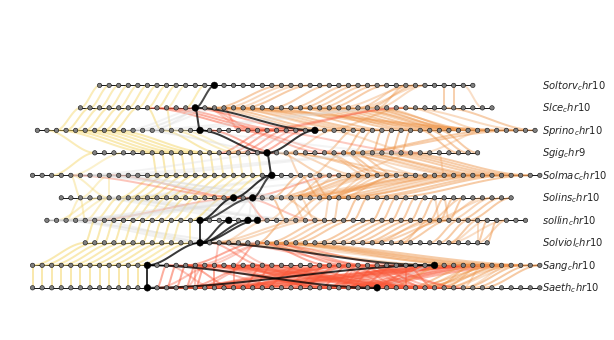

In [22]:
# Running the provided code to generate the updated visualization

fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over each sequence and find the positions of the special (black) dots
special_positions_dict = {}
for seq_name, genes in centered_gene_data.items():
    special_positions = [pos for k, pos in new_gene_to_coordinateA.items() if k[0] == seq_name]
    if special_positions:
        special_positions_dict[seq_name] = sorted(special_positions)

# Connecting similar genes with smooth ribbons (Sankey-like)
for similarity in transformed_connections2:
    (seq1, gene1), (seq2, gene2), identity, l = similarity

    y1 = gffs_indexes[seq1]
    y2 = gffs_indexes[seq2]
    x1 = centered_gene_data[seq1][gene1 // length_value]
    x2 = centered_gene_data[seq2][gene2 // length_value]

    # Determine the color of the connection
    color = l[0]
    if color == 'black':
        pass
    else:
    
    
    # Check for pink condition
        if (x1 < leftmost_special_positions.get(seq1, float('inf')) and 
            x2 < leftmost_special_positions.get(seq2, float('inf'))):
            color = '#F4D35E'

        # Check for blue condition
        elif (x1 > rightmost_special_positions.get(seq1, -float('inf')) and 
              x2 > rightmost_special_positions.get(seq2, -float('inf'))):
            color = '#EE964B'

    #     Check for red condition (if both dots are special and on the same y-line)
        special_positions_seq1 = special_positions_dict.get(seq1, [])
        special_positions_seq2 = special_positions_dict.get(seq2, [])
        if (len(special_positions_seq1) > 1 and special_positions_seq1[0] < x1 < special_positions_seq1[1]) or \
           (len(special_positions_seq2) > 1 and special_positions_seq2[0] < x2 < special_positions_seq2[1]):
            color = '#F95738'


    # Create a smoother connection using Bezier curves (behind other objects)
    control1 = (x1 + (x2 - x1) / 3, y1)
    control2 = (x2 - (x2 - x1) / 3, y2)
    bezier_points = bezier_curve((x1, y1), (x2, y2), control1, control2)
    if identity < 0.8:
        alpha_value = 0
    elif color != 'black':
        alpha_value = identity - 0.5
    else:
        alpha_value = identity - 0.2

    plt.plot(bezier_points[:, 0], bezier_points[:, 1], color, lw=circle_diameter-13, alpha=alpha_value, zorder=l[1])

# Plotting the genes and sequences
for seq_name, genes in centered_gene_data.items():
    Vs = [v for k, v in new_gene_to_coordinateA.items() if k[0] == seq_name]
    color_list = ['grey' if int(i) not in Vs else 'black' for i in genes]
    size_list = [(circle_diameter / 6) ** 2 * np.pi if int(i) not in Vs else (circle_diameter / 4) ** 2 * np.pi for i in genes]
    
    y_pos = gffs_indexes[seq_name]
    plt.plot([genes[0], genes[-1]], [y_pos, y_pos], 'k-', lw=1, zorder=0)
    plt.scatter(genes, [y_pos] * len(genes), c=color_list, s=size_list, edgecolors='black', linewidths=0.5, zorder=3)
    plt.text(max_length + 5, y_pos, f'${gffs_ann[seq_name]}$', verticalalignment='center')

plt.ylim(-2, len(gffs_indexes) + 2.5)
plt.axis('off')  # Turn off axis
plt.show()


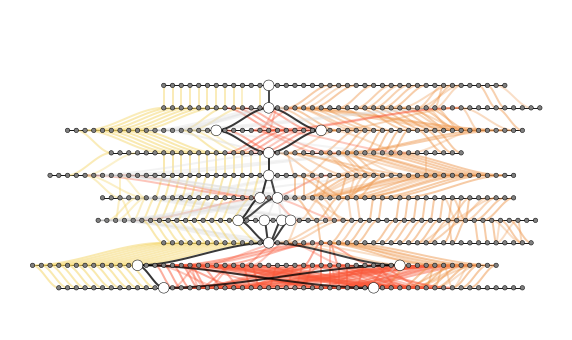

In [23]:
# Running the provided code to generate the updated visualization

fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over each sequence and find the positions of the special (black) dots
special_positions_dict = {}
for seq_name, genes in new_centered_gene_data.items():
    special_positions = [pos for k, pos in new_gene_to_coordinate.items() if k[0] == seq_name]
    if special_positions:
        special_positions_dict[seq_name] = sorted(special_positions)

# Connecting similar genes with smooth ribbons (Sankey-like)
for similarity in transformed_connections2:
    (seq1, gene1), (seq2, gene2), identity, l = similarity

    y1 = gffs_indexes[seq1]
    y2 = gffs_indexes[seq2]
    x1 = new_centered_gene_data[seq1][gene1 // length_value]
    x2 = new_centered_gene_data[seq2][gene2 // length_value]

    # Determine the color of the connection
    color = l[0]
    if color == 'black':
        pass
    else:
    
    
    # Check for pink condition
        if (x1 < new_leftmost_special_positions.get(seq1, float('inf')) and 
            x2 < new_leftmost_special_positions.get(seq2, float('inf'))):
            color = '#F4D35E'

        # Check for blue condition
        elif (x1 > new_rightmost_special_positions.get(seq1, -float('inf')) and 
              x2 > new_rightmost_special_positions.get(seq2, -float('inf'))):
            color = '#EE964B'

    #     Check for red condition (if both dots are special and on the same y-line)
        special_positions_seq1 = special_positions_dict.get(seq1, [])
        special_positions_seq2 = special_positions_dict.get(seq2, [])
        if (len(special_positions_seq1) > 1 and special_positions_seq1[0] < x1 < special_positions_seq1[1]) or \
           (len(special_positions_seq2) > 1 and special_positions_seq2[0] < x2 < special_positions_seq2[1]):
            color = '#F95738'


    # Create a smoother connection using Bezier curves (behind other objects)
    control1 = (x1 + (x2 - x1) / 3, y1)
    control2 = (x2 - (x2 - x1) / 3, y2)
    bezier_points = bezier_curve((x1, y1), (x2, y2), control1, control2)
    if identity < 0.8:
        alpha_value = 0
    elif color != 'black':
        alpha_value = identity - 0.5
    else:
        alpha_value = identity - 0.2

    plt.plot(bezier_points[:, 0], bezier_points[:, 1], color, lw=circle_diameter-13, alpha=alpha_value, zorder=l[1])

# Plotting the genes and sequences
for seq_name, genes in new_centered_gene_data.items():
    Vs = [v for k, v in new_gene_to_coordinate.items() if k[0] == seq_name]
    color_list = ['grey' if int(i) not in Vs else 'white' for i in genes]
    size_list = [(circle_diameter / 6) ** 2 * np.pi if int(i) not in Vs else (circle_diameter / 2.5) ** 2 * np.pi for i in genes]
    
    y_pos = gffs_indexes[seq_name]
    plt.plot([genes[0], genes[-1]], [y_pos, y_pos], 'k-', lw=1, zorder=0)
    plt.scatter(genes, [y_pos] * len(genes), c=color_list, s=size_list, edgecolors='black', linewidths=0.5, zorder=3)
#     plt.text(max_length + 205, y_pos, f'${gffs_ann[seq_name]}$', verticalalignment='center')

plt.ylim(-2, len(gffs_indexes) + 2.5)
plt.axis('off')  # Turn off axis
plt.show()
# fig.savefig("/Users/igentile/Desktop/Clinker_CLV3_extended_torvum_Final.pdf", dpi=600, bbox_inches='tight', format='pdf')



 # TE Analysis 

In [24]:
import os
from collections import defaultdict
from tqdm import tqdm

def identify_transposon_classes(gff_files):
    transposon_classes = set()
    for file in tqdm(gff_files, desc="Processing GFF files"):
        with open(file, 'r') as f:
            for line in f:
                if line.startswith("#"):
                    continue
                parts = line.split("\t")
                if len(parts) > 2 and parts[1] == "EDTA":
                    transposon_classes.add(parts[2])
    return transposon_classes

def compute_density_per_three_genes(gff_file, transposon_classes, gene_list):
    gene_positions = []
    gene_names = {}
    transposon_positions = defaultdict(list)
    
    total_lines = sum(1 for _ in open(gff_file, 'r'))
    
    with open(gff_file, 'r') as f:
        for line in tqdm(f, total=total_lines, desc="Parsing GFF file"):
            if line.startswith("#"):
                continue
            parts = line.strip().split("\t")
            if len(parts) < 9:
                continue
            
            start, end = int(parts[3]), int(parts[4])
            
            if parts[2] == "gene":
                gene_name = next((attr.split('=')[1] for attr in parts[8].split(';') if attr.startswith("ID=")), None)
                
                gene_name=gene_name.replace('gene:','')
                if gene_name and gene_name in gene_list:
                    gene_positions.append((start, end))
                    gene_names[(start, end)] = gene_name
            elif parts[1] == "EDTA" and parts[2] in transposon_classes:
                transposon_positions[parts[2]].append((start, end))

    densities = {}
    for i in tqdm(range(0, len(gene_positions) - 2, 3), desc="Computing densities"):
        region_start = gene_positions[i][0] if i == 0 else (gene_positions[i-1][1] + gene_positions[i][0]) // 2
        region_end = gene_positions[i+2][1] if i+3 >= len(gene_positions) else (gene_positions[i+2][1] + gene_positions[i+3][0]) // 2

        density = {cls: 0 for cls in transposon_classes}
        for cls, positions in transposon_positions.items():
            density[cls] = sum(1 for pos in positions if region_start <= pos[0] <= region_end)

        gene_block_key = tuple(gene_names[gene_positions[j]] for j in range(i, i+3))
        densities[gene_block_key] = density

    return densities



In [25]:
_=[]
for i in gene_data:
    for g in gene_data[i][9]:
        if g not in _:
            _.append(g)

In [26]:
import glob
    
gff_files = glob.glob("/Users/igentile/Desktop/Plus_EDTE/*.gff")
print(f"Found {len(gff_files)} GFF files")

transposon_classes = identify_transposon_classes(gff_files)
print(f"Identified {len(transposon_classes)} transposon classes")

gene_list = set([i for i in _])  # Using a set for faster lookup

all_TE = {}
for gff in tqdm(gff_files, desc="Processing GFF files"):
    print(f"\nProcessing: {gff}")
    densities = compute_density_per_three_genes(gff, transposon_classes, gene_list)
    for k, v in densities.items():
        all_TE[tuple(i for i in k)] = v

print(f"\nTotal gene blocks processed: {len(all_TE)}")
print("Sample of results:")
for k, v in list(all_TE.items())[:5]:
    print(f"Genes: {k}")
    print(f"Transposon counts: {v}\n")

Found 10 GFF files


Processing GFF files: 100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


Identified 31 transposon classes


Processing GFF files:   0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-24-2a01905c6de6>:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_lines = sum(1 for _ in open(gff_file, 'r'))



Processing: /Users/igentile/Desktop/Plus_EDTE/Solpri1_merged_sorted.gff



Parsing GFF file: 100%|██████████| 1999102/1999102 [00:03<00:00, 591963.12it/s]

Computing densities:   0%|          | 0/17 [00:00<?, ?it/s]<ipython-input-24-2a01905c6de6>:51: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  density[cls] = sum(1 for pos in positions if region_start <= pos[0] <= region_end)

Processing GFF files:  10%|█         | 1/10 [00:07<01:03,  7.08s/it]


Processing: /Users/igentile/Desktop/Plus_EDTE/Solmac3_merged_sorted.gff



Parsing GFF file: 100%|██████████| 2230730/2230730 [00:03<00:00, 596192.02it/s]

Processing GFF files:  20%|██        | 2/10 [00:15<01:00,  7.61s/it]


Processing: /Users/igentile/Desktop/Plus_EDTE/Sollin1_merged_sorted.gff



Parsing GFF file: 100%|██████████| 1967431/1967431 [00:03<00:00, 618917.84it/s]

Processing GFF files:  30%|███       | 3/10 [00:21<00:49,  7.10s/it]


Processing: /Users/igentile/Desktop/Plus_EDTE/Solcle2_merged_sorted.gff



Parsing GFF file: 100%|██████████| 1682444/1682444 [00:02<00:00, 626788.29it/s]

Processing GFF files:  40%|████      | 4/10 [00:27<00:39,  6.51s/it]


Processing: /Users/igentile/Desktop/Plus_EDTE/Solang8_merged_sorted.gff



Parsing GFF file: 100%|██████████| 2024267/2024267 [00:03<00:00, 597764.76it/s]

Processing GFF files:  50%|█████     | 5/10 [00:34<00:33,  6.77s/it]


Processing: /Users/igentile/Desktop/Plus_EDTE/Solgig1_merged_sorted.gff



Parsing GFF file: 100%|██████████| 2357950/2357950 [00:03<00:00, 616783.87it/s]

Processing GFF files:  60%|██████    | 6/10 [00:41<00:27,  6.99s/it]


Processing: /Users/igentile/Desktop/Plus_EDTE/Soltor1_merged_sorted.gff



Parsing GFF file: 100%|██████████| 2309891/2309891 [00:03<00:00, 626755.00it/s]

Processing GFF files:  70%|███████   | 7/10 [00:49<00:21,  7.10s/it]


Processing: /Users/igentile/Desktop/Plus_EDTE/Solaet3_merged_sorted.gff



Parsing GFF file: 100%|██████████| 2011955/2011955 [00:03<00:00, 626058.37it/s]

Processing GFF files:  80%|████████  | 8/10 [00:56<00:14,  7.09s/it]


Processing: /Users/igentile/Desktop/Plus_EDTE/Solvio1_merged_sorted.gff



Parsing GFF file: 100%|██████████| 2086644/2086644 [00:03<00:00, 619704.99it/s]

Processing GFF files:  90%|█████████ | 9/10 [01:02<00:06,  6.91s/it]


Processing: /Users/igentile/Desktop/Plus_EDTE/Solins1_merged_sorted.gff



Parsing GFF file: 100%|██████████| 2026374/2026374 [00:03<00:00, 624860.90it/s]

Processing GFF files: 100%|██████████| 10/10 [01:09<00:00,  6.94s/it]


Total gene blocks processed: 151
Sample of results:
Genes: ('Solpri1_10g003200', 'Solpri1_10g003210', 'Solpri1_10g003220')
Transposon counts: {'Tc1_Mariner_TIR_transposon': 34, 'long_terminal_repeat': 2, 'Endogenous_Retrovirus_LTR_retrotransposon': 0, 'TRIM': 0, 'Bel_Pao_LTR_retrotransposon': 0, 'chloroplast_DNA': 19, 'Retrovirus_LTR_retrotransposon': 0, 'helitron': 44, 'PILE_TIR_transposon': 0, 'pararetrovirus': 0, 'low_complexity': 0, 'LTR_retrotransposon': 9, '25S_rRNA_gene': 0, '5_8S_rRNA_gene': 0, 'rDNA_intergenic_spacer_element': 0, 'PIF_Harbinger_TIR_transposon': 7, 'LINE_element': 0, 'repeat_region': 44, '5S_rRNA_gene': 0, 'RTE_LINE_retrotransposon': 42, 'Copia_LTR_retrotransposon': 27, '18S_rRNA_gene': 0, 'mitochondrial_DNA': 9, 'Mutator_TIR_transposon': 56, 'CACTA_TIR_transposon': 15, 'Gypsy_LTR_retrotransposon': 14, 'L1_LINE_retrotransposon': 4, 'hAT_TIR_transposon': 35, 'target_site_duplication': 2, 'ERTBV_retrotransposon': 0, 'SINE_element': 1}

Genes: ('Solpri1_10g003230

In [28]:
new_centered_gene_data_detailed={}
for k in organized_gene_data_detailed.keys():
    new_centered_gene_data_detailed[k]={}
    for i,j in zip(new_centered_gene_data[k],organized_gene_data_detailed[k].keys()):
        new_centered_gene_data_detailed[k][j]=int(i)


In [30]:
adj_all_TE={}
for k in new_centered_gene_data_detailed.keys():
    adj_all_TE[k]={}
    
for k,v in all_TE.items():
    for k_1 in new_centered_gene_data_detailed.keys():
        temp=k_1.split('/')[-1].split('_')[-2]
        
        if '_Slce' in k_1:
            temp='cle2'
        elif 'Soltor' in  k_1:
            temp='Soltor1'
        elif 'Sang' in   k_1:
            temp='ang'
        elif 'Saeth_' in k_1:
            temp='aet'
        elif 'Sprino' in k_1:
            temp='pri'
        elif 'llin' in  k_1:
            temp='llin1'
        elif 'gig' in k_1:
            temp='gig'
        elif 'Solviol' in k_1:
            temp='vio1'
        

#         print(temp)
#         print(k[0])
        if temp in k[0]:
#             print(f'{temp} in {k[0]}')
            mykey=k_1
            
            continue
        
    _=[]
    for i in k:
        try:
            _.append(new_centered_gene_data_detailed[mykey][i])
        except:
            pass
    if len(tuple(sorted(_))) > 0:
        adj_all_TE[mykey][tuple(sorted(_))]=v
        

In [31]:
_={}

for m in adj_all_TE.keys():
    _[m]={}
    for g,d in adj_all_TE[m].items():
        try:
            _[m][int(mean(g))]=[v for k,v in adj_all_TE[m][g].items() if k=='mitochondrial_DNA' ]
        except:
            pass

In [32]:
what_to_what={}
for k,v in adj_all_TE.items():
    what_to_what[k]={}
    for k1,v1 in v.items():
        for i in k1:
            what_to_what[k][i]=int(mean(k1))


In [33]:
te_colors = [
    "#1f77b4",  # muted blue
    "#ff7f0e",  # safety orange
    "#2ca02c",  # cooked asparagus green
    "#d62728",  # brick red
    "#9467bd",  # muted purple
    "#8c564b",  # chestnut brown
    "#e377c2",  # raspberry yogurt pink
    "#7f7f7f",  # middle gray
    "#bcbd22",  # curry yellow-green
    "#17becf",  # blue-teal
    
    "#9edae5",  # light blue
    "#dbdb8d",  # pastel yellow
    "#c5b0d5",  # light purple
    "#c49c94",  # light brown
    "#f7b6d2",  # light pink
    "#c7c7c7",  # light gray
    "#aec7e8",  # another light blue
    "#ffbb78",  # light orange
    "#98df8a",  # light green
    "#ff9896" ,"#9edae5",  # light blue
    "#dbdb8d",  # pastel yellow
    "#c5b0d5",  # light purple
    "#c49c94",  # light brown
    "#f7b6d2",  # light pink
    "#c7c7c7",  # light gray
    "#aec7e8",  # another light blue
    "#ffbb78",  # light orange
    "#98df8a",  # light green
    "#ff9896",'#ffffff'   # light red
]

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean

def bezier_curve(start, end, control1, control2, num_points=100):
    t = np.linspace(0, 1, num_points)
    x = (1-t)**3 * start[0] + 3*(1-t)**2 * t * control1[0] + 3*(1-t) * t**2 * control2[0] + t**3 * end[0]
    y = (1-t)**3 * start[1] + 3*(1-t)**2 * t * control1[1] + 3*(1-t) * t**2 * control2[1] + t**3 * end[1]
    return np.column_stack((x, y))

def plot_stacked_te(adj_all_TE, gffs_indexes, new_centered_gene_data, new_gene_to_coordinate, gffs_ann, max_length, circle_diameter, transformed_connections2, new_leftmost_special_positions, new_rightmost_special_positions, length_value):
    fig, ax = plt.subplots(figsize=(15, 25))
    
    te_types = set()
    for seq_data in adj_all_TE.values():
        for pos_data in seq_data.values():
            te_types.update(pos_data.keys())
    te_types = sorted(te_types)
    
    color_map = plt.cm.get_cmap('tab20')
    te_colors = {te: color_map(i/len(te_types)) for i, te in enumerate(te_types)}
    
    max_total_count = max(
        sum(count for count in pos_data.values() if isinstance(count, (int, float)))
        for seq_data in adj_all_TE.values()
        for pos_data in seq_data.values()
    )
    
    for similarity in transformed_connections2:
        (seq1, gene1), (seq2, gene2), identity, l = similarity
        y1 = gffs_indexes[seq1]
        y2 = gffs_indexes[seq2]
        x1 = new_centered_gene_data[seq1][gene1 // length_value]
        x2 = new_centered_gene_data[seq2][gene2 // length_value]
        
        color = l[0]
        if color == 'black':
            pass
        else:
            if (x1 < new_leftmost_special_positions.get(seq1, float('inf')) and 
                x2 < new_leftmost_special_positions.get(seq2, float('inf'))):
                color = '#F4D35E'
            elif (x1 > new_rightmost_special_positions.get(seq1, -float('inf')) and 
                  x2 > new_rightmost_special_positions.get(seq2, -float('inf'))):
                color = '#EE964B'
            elif (new_leftmost_special_positions.get(seq1, float('inf')) <= x1 <= new_rightmost_special_positions.get(seq1, -float('inf')) and
                  new_leftmost_special_positions.get(seq2, float('inf')) <= x2 <= new_rightmost_special_positions.get(seq2, -float('inf'))):
                color = '#F95738'
        
        control1 = (x1 + (x2 - x1) / 3, y1)
        control2 = (x2 - (x2 - x1) / 3, y2)
        bezier_points = bezier_curve((x1, y1), (x2, y2), control1, control2)
        
        if identity < 0.8:
            alpha_value = 0
        elif color != 'black':
            alpha_value = identity - 0.5
        else:
            alpha_value = identity - 0.2
        
        if color == 'black':
            ax.plot(bezier_points[:, 0], bezier_points[:, 1], color, lw=circle_diameter-13, alpha=alpha_value, zorder=l[1])
    
    for seq_name, seq_data in adj_all_TE.items():
        y_pos = gffs_indexes[seq_name]
        genes = new_centered_gene_data[seq_name]
        
        ax.plot([genes[0], genes[-1]], [y_pos, y_pos], 'k-', lw=1, zorder=0)
        
        Vs = [v for k, v in new_gene_to_coordinate.items() if k[0] == seq_name]
        
        color_list = ['white' if int(i) in Vs else 'grey' for i in range(len(genes))]
        size_list = [(circle_diameter / 2.5) ** 2 * np.pi if int(i) in Vs else (circle_diameter / 6) ** 2 * np.pi for i in range(len(genes))]
        
        ax.scatter(genes, [y_pos] * len(genes), c=color_list, s=size_list, edgecolors='black', linewidths=0.5, zorder=3)
        
        te_positions = {}
        for g, te_counts in seq_data.items():
            mean_pos = int(mean(g))
            te_positions[mean_pos] = te_counts
        
        for x_pos, te_counts in te_positions.items():
            bottom = 0
            normalization_factor = 0.9 / max_total_count if max_total_count > 0 else 0
            
            for te in te_types:
                height = te_counts.get(te, 0) * normalization_factor
                if isinstance(height, (int, float)) and height > 0:
                    ax.bar(x_pos, height, bottom=y_pos + bottom, width=circle_diameter*3.5, 
                           color=te_colors[te], edgecolor='none', alpha=0.7, zorder=2)
                    bottom += height
        
        ax.text(max_length + 205, y_pos, f'${gffs_ann[seq_name]}$', verticalalignment='center')
    
    ax.set_ylim(-2, len(gffs_indexes) + 2.5)
    ax.set_xlim(0, max_length + 400)
    ax.axis('off')
    
    handles = [plt.Rectangle((0,0),1,1, color=te_colors[te]) for te in te_types]
    plt.legend(handles, te_types, loc='center left', bbox_to_anchor=(1, 0.5), 
               ncol=2, fontsize='small')
    
    plt.tight_layout()
#     fig.savefig(f"/Users/igentile/Desktop/ALL_TE_Clinker_CLV3_extended_torvum_new.pdf", dpi=600, bbox_inches='tight', format='pdf')

    plt.show()



<ipython-input-34-75e67d6fe03a>:24: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum(count for count in pos_data.values() if isinstance(count, (int, float)))


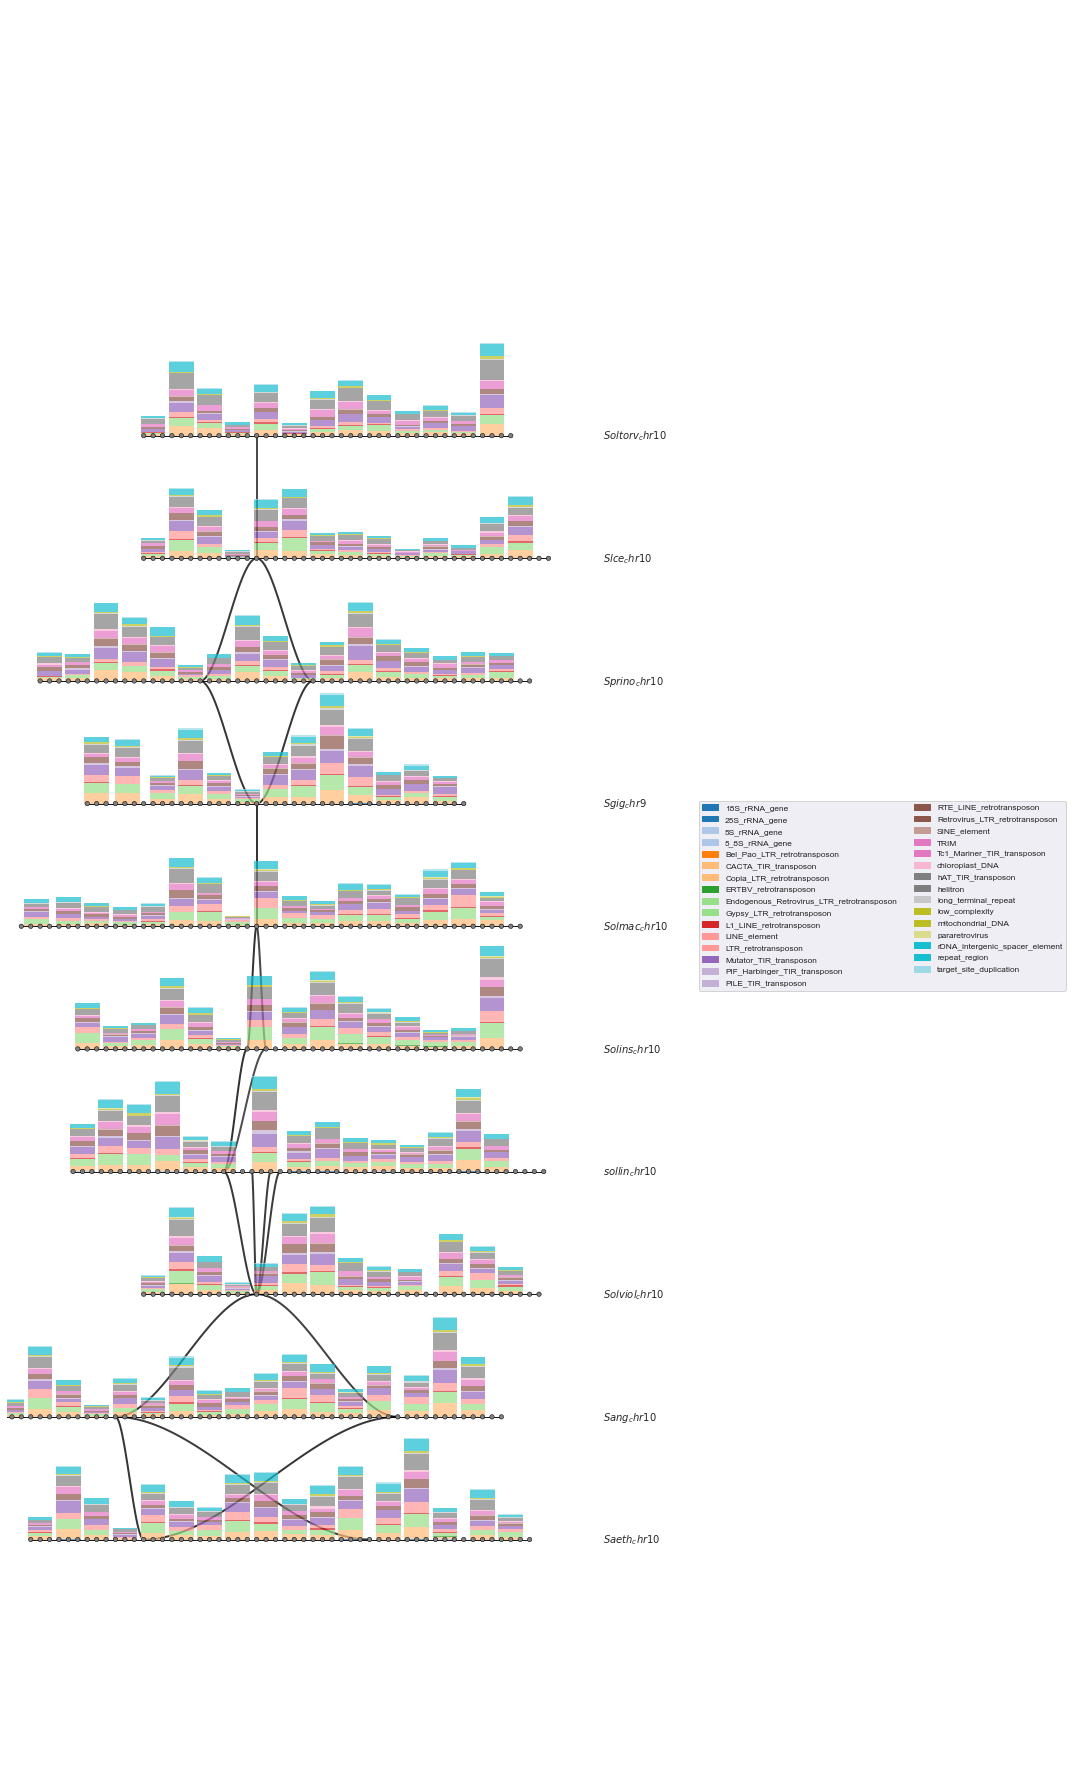

In [35]:
plot_stacked_te(adj_all_TE, gffs_indexes, new_centered_gene_data, new_gene_to_coordinate, gffs_ann, max_length, circle_diameter, transformed_connections2, new_leftmost_special_positions, new_rightmost_special_positions, length_value)

# R Genes

In [36]:
Rgenes=['Solaet3_10g003800',
 'Solaet3_10g003860',
 'Solaet3_10g003900',
 'Solaet3_10g003910',
 'Solaet3_10g003960',
 'Solaet3_10g004010',
 'Solaet3_10g004060',
 'Solaet3_10g004090',
 'Solang8_10g003860',
 'Solang8_10g003920',
 'Solang8_10g003980',
 'Solang8_10g004010',
 'Solang8_10g004050',
 'Solang8_10g004090',
 'Solang8_10g004100',
 'Solang8_10g004170',
 'Solang8_10g004210',
 'Solcle2_10g003130',
 'Solcle2_10g003340',
 'Solgig1_09g003100',
 'Solgig1_09g003120',
 'Solgig1_09g003290',
 'Solgig1_09g003300',
 'Solgig1_09g003330',
 'Solgig1_09g003450',
 'Solins1_10g003370',
 'Solins1_10g003400',
 'Solins1_10g003540',
 'Solins1_10g003550',
 'Solins1_10g003590',
 'Sollin1_10g003280',
 'Sollin1_10g003300',
 'Sollin1_10g003430',
 'Sollin1_10g003440',
 'Sollin1_10g003460',
 'Sollin1_10g003510',
 'Solmac3_10g003440',
 'Solmac3_10g003480',
 'Solmac3_10g003490',
 'Solmac3_10g003500',
 'Solmac3_10g003670',
 'Solmac3_10g003720',
 'Solmac3_10g003840',
 'Solpri1_10g003320',
 'Solpri1_10g003420',
 'Solpri1_10g003430',
 'Solpri1_10g003500',
 'Solpri1_10g003670',
 'Solpri1_10g003690',
 'Soltor1_10g003360',
 'Soltor1_10g003380',
 'Soltor1_10g003530',
 'Solvio1_10g003520']


In [37]:
alignments_df=alignments_df[alignments_df['Similarity']!= 'Similarity']


In [38]:
connections=[(a,b) for a,b,z in zip(alignments_df['Query'],alignments_df['Target'],alignments_df['Similarity']) if float(z)> 0.7]


In [39]:
Rgenes_2=[]
for i in connections:
    for j in i:
        if  j.split('.')[0] in Rgenes:
            Rgenes_2.append(j.split('.')[0])

In [40]:
import networkx as nx

G = nx.Graph()

G.add_edges_from([(a,b) for a,b in zip(alignments_df['Query'],alignments_df['Target'])])

connected_components = list(nx.connected_components(G))

In [41]:
Rgenes=[i for i in connected_components if len([j.split('.')[0] for j in i if j.split('.')[0] in Rgenes_2])>0]

In [42]:
Rgenes=[j.split('.')[0] for i in Rgenes for j in i]

In [43]:
new_centered_gene_data_detailed={}
for k in organized_gene_data_detailed.keys():
    new_centered_gene_data_detailed[k]={}
    for i,j in zip(new_centered_gene_data[k],organized_gene_data_detailed[k].keys()):
        new_centered_gene_data_detailed[k][j]=int(i)


In [44]:
at_to_at={}
for k,v in new_centered_gene_data_detailed.items():
    for k1,v1 in v.items():
        at_to_at[k1]=k

In [45]:
Rgenes_3=[i for i in Rgenes]


In [47]:
# Rgenes_3

In [48]:
Rgenes_index={}
for k in new_centered_gene_data_detailed.keys():
    Rgenes_index[k]=[]
for i in Rgenes_3:
    try:
        Rgenes_index[at_to_at[i]].append(new_centered_gene_data_detailed[at_to_at[i]][i])
    except:
        print(i)
        pass

Solgig1_09g003130
Sollin1_10g003450


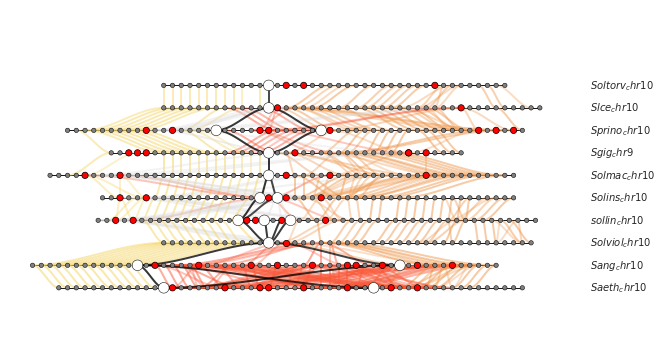

In [49]:
# Running the provided code to generate the updated visualization

fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over each sequence and find the positions of the special (black) dots
special_positions_dict = {}
for seq_name, genes in new_centered_gene_data.items():
    special_positions = [pos for k, pos in new_gene_to_coordinate.items() if k[0] == seq_name]
    if special_positions:
        special_positions_dict[seq_name] = sorted(special_positions)

# Connecting similar genes with smooth ribbons (Sankey-like)
for similarity in transformed_connections2:
    (seq1, gene1), (seq2, gene2), identity, l = similarity

    y1 = gffs_indexes[seq1]
    y2 = gffs_indexes[seq2]
    x1 = new_centered_gene_data[seq1][gene1 // length_value]
    x2 = new_centered_gene_data[seq2][gene2 // length_value]

    # Determine the color of the connection
    color = l[0]
    if color == 'black':
        pass
    else:
    
    
    # Check for pink condition
        if (x1 < new_leftmost_special_positions.get(seq1, float('inf')) and 
            x2 < new_leftmost_special_positions.get(seq2, float('inf'))):
            color = '#F4D35E'

        # Check for blue condition
        elif (x1 > new_rightmost_special_positions.get(seq1, -float('inf')) and 
              x2 > new_rightmost_special_positions.get(seq2, -float('inf'))):
            color = '#EE964B'

    #     Check for red condition (if both dots are special and on the same y-line)
        special_positions_seq1 = special_positions_dict.get(seq1, [])
        special_positions_seq2 = special_positions_dict.get(seq2, [])
        if (len(special_positions_seq1) > 1 and special_positions_seq1[0] < x1 < special_positions_seq1[1]) or \
           (len(special_positions_seq2) > 1 and special_positions_seq2[0] < x2 < special_positions_seq2[1]):
            color = '#F95738'


    # Create a smoother connection using Bezier curves (behind other objects)
    control1 = (x1 + (x2 - x1) / 3, y1)
    control2 = (x2 - (x2 - x1) / 3, y2)
    bezier_points = bezier_curve((x1, y1), (x2, y2), control1, control2)
    if identity < 0.8:
        alpha_value = 0
    elif color != 'black':
        alpha_value = identity - 0.5
    else:
        alpha_value = identity - 0.2

    plt.plot(bezier_points[:, 0], bezier_points[:, 1], color, lw=circle_diameter-13, alpha=alpha_value, zorder=l[1])

# Plotting the genes and sequences
for seq_name, genes in new_centered_gene_data.items():
    Vs = [v for k, v in new_gene_to_coordinate.items() if k[0] == seq_name]
    
    y_pos = gffs_indexes[seq_name]
    plt.plot([genes[0], genes[-1]], [y_pos, y_pos], 'k-', lw=1, zorder=0)
    rgenes=Rgenes_index[seq_name]
    genes=[i for i in genes if i not in rgenes]
    color_list = ['grey' if int(i) not in Vs else 'white' for i in genes]
    size_list = [(circle_diameter / 6) ** 2 * np.pi if int(i) not in Vs else (circle_diameter / 2.5) ** 2 * np.pi for i in genes]
    
    
    
    rgenes=Rgenes_index[seq_name]
    genes=[i for i in genes if i not in rgenes]
    plt.scatter(genes, [y_pos] * len(genes), c=color_list, s=size_list, edgecolors='black', linewidths=0.5, zorder=3)
    
    plt.scatter(rgenes, [y_pos] * len(rgenes), c=['red' for i in rgenes], s=40, edgecolors='black', linewidths=.7, zorder=3)

    plt.text(max_length + 205, y_pos, f'${gffs_ann[seq_name]}$', verticalalignment='center')

plt.ylim(-2, len(gffs_indexes) + 2.5)
plt.axis('off')  # Turn off axis
plt.show()
# fig.savefig("/Users/igentile/Desktop/R_genes_Clinker_CLV3_extended_torvum_new.pdf", dpi=600, bbox_inches='tight', format='pdf')

